### Neural network potential example - 1D chain of atoms.
This example involves fitting a neural network potential to a target potential for a 1D chain of atoms. The target potential is defined by us - a simple harmonic potential. This target potential will serve as our "ab initio" potential in this example.

In [1]:
"""
Import modules
"""
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch import tensor

In [2]:
"""
Define 1D configurations of atoms.
These will be displacements of a 1D chain, where the equilibrium distance is "1".
"""
natoms = 32
nconfigs = 1000
rc = 1.5

# Define indices upon which to contract per-atom energies
indices = []
for m in range(0,nconfigs):
    for i in range(0,natoms):
        indices.append(m)
indices = torch.tensor(indices, dtype=torch.int64)
print(indices)

# Descriptor params.
# Each row is a different descriptor parameter set, so number of rows = number of descriptors. 
dparams = [[0.1,0.5],
           [0.1,2.0],
           [0.01,0.01],
           [0.01,0.1],
           [0.01,0.15],
           [0.01,0.2],
           [0.2,3.0],
           [0.3,4.0]]
dparams = np.array(dparams)
nd = np.shape(dparams)[0] # number of descriptors

# Torch params
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Box size for 1D system of atoms
x_size = float(natoms)
x_rsize = 1.0 / x_size;

x0 = []
for i in range(0,natoms):
    x0.append(float(i))
x0 = np.array(x0)
#print(x0)

# Define all configs
x_all = [x0]
for m in range(0,nconfigs-1):
    x_tmp = []
    for i in range(0,natoms):
        x_tmp.append(np.random.normal(loc=x0[i],scale=0.1*1))
    x_all.append(x_tmp)
x_all =  np.array(x_all)

print(x_all)

tensor([  0,   0,   0,  ..., 999, 999, 999])
[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00 ...  2.90000000e+01
   3.00000000e+01  3.10000000e+01]
 [ 9.21361808e-02  1.14341967e+00  1.99089581e+00 ...  2.90056677e+01
   2.98505277e+01  3.10982891e+01]
 [-1.49202552e-01  1.03690512e+00  1.89838433e+00 ...  2.88457981e+01
   3.00398364e+01  3.10397523e+01]
 ...
 [ 8.71978048e-02  1.07599648e+00  2.14432947e+00 ...  2.89122607e+01
   2.99009292e+01  3.10577389e+01]
 [-1.84626044e-02  1.04153270e+00  1.96620470e+00 ...  2.91992553e+01
   2.99423911e+01  3.10074828e+01]
 [ 2.39907049e-01  7.90959225e-01  1.94103920e+00 ...  2.90744486e+01
   3.00668648e+01  3.10194700e+01]]


We will use the Behler-Parinello (BP) descriptors for describing atomic environments:
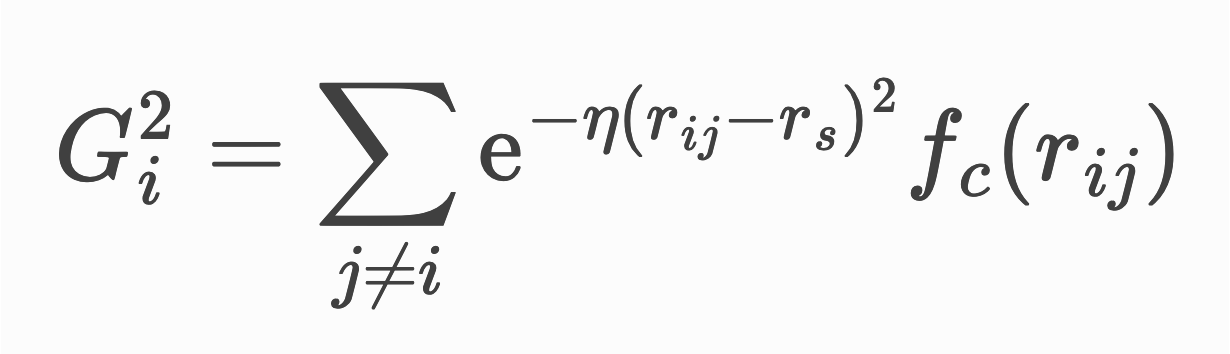
These descriptors are inputs to the neural network. 
BP descriptors are calculated below.

In [5]:
"""
Function to calculate the cutoff function used in the BP descriptors.
Input: rij - distance between two atoms.
Returns a single value of the cutoff function evaluated at a particular rij. 
"""
def fc(rij):
    value = 0.5*(np.cos((np.pi*rij)/rc) + 1)
    """
    if (rij<rc):
        value = 0.5*(np.cos((np.pi*rij)/rc) + 1)
    elif (rij>=rc):
        value = 0.0
    """
    return value

"""
Function to calculate descriptors for all atoms.
Input: x - positions of atoms in config.
Returns list of descriptors for all atoms in the config, with shape (natoms,nd)
"""
def calc_descriptors(x):
    d = np.zeros([natoms,nd]) # Allocate descriptors for this config
    
    for i in range(0,natoms):
        d_tmp = 0.0
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                #print(f'{i} {j} {xij}')
                rij = abs(xij)
                if (rij<1.5):
                    #print(f' {i} {j} {rij}')
                    for k in range(0,nd):
                        eta = dparams[k,0]
                        rs = dparams[k,1]
                        d[i,k] += np.exp(-1.0*eta*(rij-rs)**2)*fc(rij)
    return d
                    
                    
    #for k in range(0,nd):
        
    
    

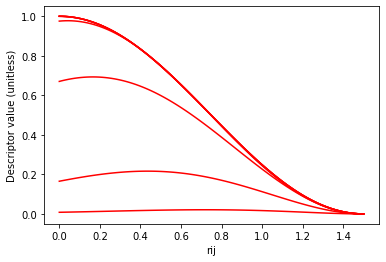

In [11]:
"""
Plot descriptors.
Visualize what the descriptors look like.
"""
def visualize_descriptors():
    rij = np.linspace(0,rc,100)
    functions = []
    #print(fc(rij))
    for k in range(0,nd):
        d_tmp = np.exp(-1.0*dparams[k,0]*(rij-dparams[k,1])**2)*fc(rij)
        #d_tmp = fc(rij)
        #functions.append(np.exp(dparams[k,0]*(rij-dparams[k,1])**2))
        #functions.append(d_tmp)
        plt.plot(rij, d_tmp, 'r')
    #functions = np.array(functions)
    plt.xlabel("rij")
    plt.ylabel("Descriptor value (unitless)")
    plt.show()
    #print(functions)
visualize_descriptors()

In [13]:
"""
Define the 2-body potential that we will fit the neural network potential to.
Input: x - positions of atoms in config.
Return forces and energy for a single config.
"""
def potential(x):
    etot = 0.
    for i in range(0,natoms):
        ei = 0.0
        for j in range(0,natoms):
            if (i!=j):
                xij = x[j]-x[i]
                xij -= x_size * round(xij * x_rsize);
                #print(f'{i} {j} {xij}')
                rij = abs(xij)
                if (rij<1.5):
                    #print(f' {i} {j} {rij}')
                    ei += (rij-1.)**2
        etot += ei
        
    return etot

In [16]:
"""
Loop through all configs and calculate energy and descriptors.
"""
targets = torch.zeros(nconfigs)
#descriptors = torch.zeros([nconfigs*natoms,nd])
descriptors = []
for m in range(0,nconfigs):
    #config = x_all[m,:]
    pe = potential(x_all[m,:])
    #print(pe)
    targets[m] = pe
    d_tmp = calc_descriptors(x_all[m,:])
    descriptors.append(d_tmp)
#print(targets)
descriptors = np.array(descriptors)
#print(np.shape(descriptors))
descriptors = np.concatenate(descriptors,axis=0)
print(np.shape(descriptors))
descriptors = torch.from_numpy(descriptors).float()
#print(descriptors)

(32000, 8)


In [23]:
"""
Define the network parameters
"""
#layer_sizes = ['num_desc', '10', '8', '6', '1'] # FitSNAP style
layer_sizes = [nd, 10, 1]
#layer_sizes = [nd,1]


In [24]:
def create_torch_network(layer_sizes):
    """
    Creates a pytorch network architecture from layer sizes.
    This also performs standarization in the first linear layer.
    ADR: No I don't think it standardizes anything...
         Actually I think the first linear layer with no activation is some form of standardization...
    This only supports softplus as the nonlinear activation function.

        Parameters:
            layer_sizes (list of ints): Size of each network layers

        Return:
            Network Architecture of type neural network sequential

    """
    layers = []
    try:
        layers.append(torch.nn.Linear(layer_sizes[0], layer_sizes[0]))
        for i, layer in enumerate(layer_sizes):
            layers.append(torch.nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(torch.nn.Softplus())
    except IndexError:
        layers.pop()
    return torch.nn.Sequential(*layers)

network_architecture = create_torch_network(layer_sizes)
print(network_architecture)
for name, param in network_architecture.named_parameters():
    print("-----")
    print(name)
    print(param)

Sequential(
  (0): Linear(in_features=8, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=10, bias=True)
  (2): Softplus(beta=1, threshold=20)
  (3): Linear(in_features=10, out_features=1, bias=True)
)
-----
0.weight
Parameter containing:
tensor([[ 0.1124, -0.0746, -0.3430,  0.0630, -0.1015, -0.3251,  0.3251, -0.3357],
        [ 0.0196, -0.3333,  0.0953, -0.3221,  0.2977,  0.3097, -0.2150,  0.1379],
        [-0.2102, -0.2089,  0.1003,  0.1343,  0.3034, -0.1767, -0.1109, -0.0283],
        [-0.1895, -0.1411,  0.1979,  0.2106,  0.2934, -0.1437,  0.1969,  0.0185],
        [ 0.2672,  0.0514, -0.3381, -0.1249,  0.0970,  0.3059, -0.1334,  0.1174],
        [-0.3023, -0.1504, -0.3429, -0.1382, -0.2082, -0.3332,  0.0845, -0.1434],
        [-0.2841,  0.2475, -0.0919, -0.2337, -0.1272,  0.0301, -0.0893, -0.2011],
        [-0.0755,  0.1067, -0.3071, -0.2219, -0.0076, -0.0798,  0.3162,  0.1094]],
       requires_grad=True)
-----
0.bias
Parameter containing:
tensor([ 0.1752, -0.19

In [25]:
"""
Define the model
"""
class FitTorch(torch.nn.Module):
    """
    FitSNAP PyTorch Neural Network Architecture Model
    Currently only fits on energies
    """

    def __init__(self, network_architecture, descriptor_count, n_elements=1):
        """
        Saves lammps ready pytorch model.

            Parameters:
                network_architecture : A nn.Sequential network architecture
                descriptor_count (int): Length of descriptors for an atom
                n_elements (int): Number of differentiable atoms types

        """
        super().__init__()
        self.network_architecture = network_architecture
        self.desc_len = descriptor_count
        self.n_elem = n_elements
        
    def forward(self, x, indices, atoms_per_structure):
        """
        Saves lammps ready pytorch model.

            Parameters:
                x (tensor of floats): Array of descriptors
                indices (tensor of ints): Array of indices upon which to contract per atom energies
                atoms_per_structure (tensor of ints): Number of atoms per configuration

        """

        predicted_energy_total = torch.zeros(atoms_per_structure.size())
        predicted_energy_total.index_add_(0, indices, self.network_architecture(x).squeeze())
        return predicted_energy_total

    def import_wb(self, weights, bias):
        """
        Imports weights and bias into FitTorch model

            Parameters:
                weights (list of numpy array of floats): Network weights at each layer
                bias (list of numpy array of floats): Network bias at each layer

        """

        assert len(weights) == len(bias)
        imported_parameter_count = sum(w.size + b.size for w, b in zip(weights, bias))
        combined = [None] * (len(weights) + len(bias))
        combined[::2] = weights
        combined[1::2] = bias

        assert len([p for p in self.network_architecture.parameters()]) == len(combined)
        assert sum(p.nelement() for p in self.network_architecture.parameters()) == imported_parameter_count

        state_dict = self.state_dict()
        for i, key in enumerate(state_dict.keys()):
            state_dict[key] = torch.tensor(combined[i])
        self.load_state_dict(state_dict)

In [26]:
"""
Create the model.
"""
model = FitTorch(network_architecture, nd)
print(model)
#print(model.network_architecture,0,weight)

FitTorch(
  (network_architecture): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=10, bias=True)
    (2): Softplus(beta=1, threshold=20)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [28]:
"""
Define energy calculation parameters
"""
num_atoms = 8*torch.ones(nconfigs,dtype=torch.int32) # number of atoms per config
#print(descriptors)
#print(indices)
print(type(num_atoms))
test = model(descriptors, indices, num_atoms)
#print(test)
energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
#print(energies)
print(type(energies))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [29]:
"""
Define training objects
"""
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)


In [30]:
"""
Train
"""
for epoch in range(1000):
    energies = torch.reshape(model(descriptors, indices, num_atoms), (-1,)).to(device)
    loss = loss_function(energies/num_atoms, targets)
    if (epoch % 100 == 0):
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 1, loss = 0.1661
epoch: 101, loss = 0.1281
epoch: 201, loss = 0.0703
epoch: 301, loss = 0.0308
epoch: 401, loss = 0.0125
epoch: 501, loss = 0.0088
epoch: 601, loss = 0.0099
epoch: 701, loss = 0.0070
epoch: 801, loss = 0.0068
epoch: 901, loss = 0.0112


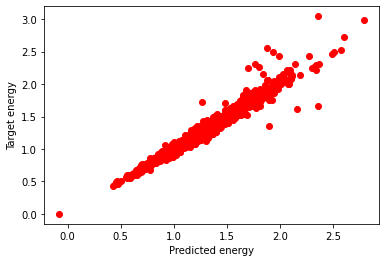

In [32]:
# Plot
predicted = model(descriptors,indices,num_atoms).detach().numpy()

plt.plot(predicted/num_atoms, targets.numpy(), 'ro')
plt.xlabel("Predicted energy")
plt.ylabel("Target energy")
plt.show()